# Data

### Libraries

In [37]:
# import libraries

import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Data preparation

In [38]:
def load_filtered_data(city):
    '''
    Load filtered data from a city
    '''
    file = ['business', 'checkin', 'review', 'tip', 'user']
    data = {}
    for f in file:
        data[f] = pd.read_csv(f'../filtered_cities/{city}_{f}.csv')
    return data

In [39]:
# load data

city = 'St. Louis'
data = load_filtered_data(city)

In [40]:
# review data

data['review'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63451 entries, 0 to 63450
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    63451 non-null  object
 1   user_id      63451 non-null  object
 2   business_id  63451 non-null  object
 3   stars        63451 non-null  int64 
 4   useful       63451 non-null  int64 
 5   funny        63451 non-null  int64 
 6   cool         63451 non-null  int64 
 7   text         63451 non-null  object
 8   date         63451 non-null  object
dtypes: int64(4), object(5)
memory usage: 4.4+ MB


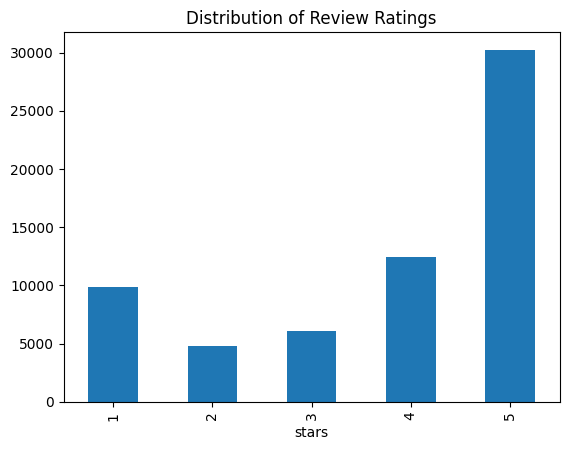

In [41]:
# distribution of review ratings

data['review']['stars'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Ratings')
plt.show()

In [43]:
def sentiment(rating):
    '''
    Return sentiment value based on rating (-1 for negative, 0 for neutral, 1 for positive)
    '''
    if rating == 1 or rating == 2:
        return -1
    elif rating == 3:
        return 0
    elif rating == 4 or rating == 5:
        return 1

In [44]:
# dataframe with reviews and sentiment values (based on stars)

reviews = data['review'].copy()
reviews['sentiment'] = reviews['stars'].apply(sentiment)
review_df = reviews[['review_id', 'text', 'sentiment']]

review_df

review_id  \
0      NvusujU9_5pIUbn9SZ6hMA   
1      vHOeBa7aMA_na4rfS2Db5A   
2      hG9RTxxivb0ZXzEk4JXTXA   
3      zIVkwgahZjOneChZFUYY4g   
4      DLczAuvMAlAnY5EeDGhTVg   
...                       ...   
63446  OgoBp7fbXnLSKvsQb4O_tw   
63447  Q7e8EtZMmdknDrQE7huMoQ   
63448  zzMW6zbsFaQMjoGu2bGVdA   
63449  scgoa60EvhW2Mz7JMqLYGw   
63450  M7NAWZ9P99ucR66LrxrUOQ   

                                                    text  sentiment  
0      Stopped by to munch a burger during today's Se...          1  
1      Yelp doesn't allow to leave 0 star review, so ...         -1  
2      I find it hard to believe there are so many pe...         -1  
3      Love this place! Almost all of their menu item...          1  
4      Excellent customer service. I wish I could ren...          1  
...                                                  ...        ...  
63446  I really loved the food and service. I mean, t...          1  
63447  Their Grove location was the bomb. Delicious f...          1  
63448  A nice ean BBQ joint right across from some ne...          1  
63449  The perfect Hookah bar. I'm not sure what they...          1  
63450  Besides it being super busy often, usually, I ...          0  

[63451 rows x 3 columns]

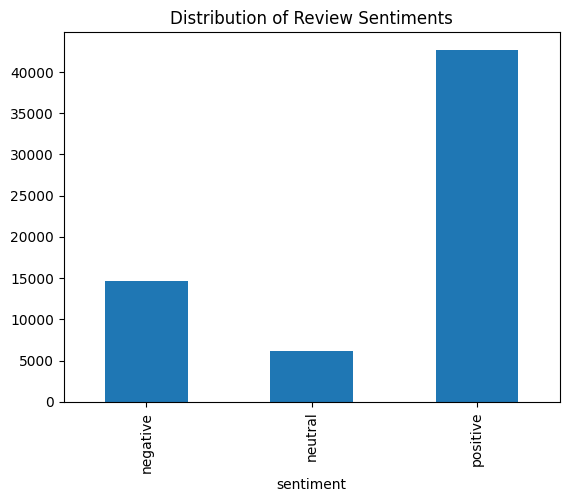

In [45]:
# distribution of sentiment values

review_df['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Sentiments')
plt.xticks(ticks=[0, 1, 2], labels=['negative', 'neutral', 'positive'])
plt.show()

In [46]:
# save review data

review_df.to_csv(f'data/review_sentiment.csv', index=False)

### Text processing

In [12]:
# see content of reviews

for review in review_df['text'].head(5).values:
    print('-' * 50)
    print(review)

--------------------------------------------------
Stopped by to munch a burger during today's Seahawks/Saints game, and the place was, unsurprisingly, packed. For good reason, too: the Haven burger I ordered was fantastic.

I sat right next to the door, so I didn't get the chance to get more than six feet into the place; as soon as I got my meal, the place started getting busier and busier until I had to work my way through the World's Shortest People Maze to get out. Guess that means I wasn't the first person to hear about the place.

I will be going back to the Haven. Might go for, say lunch on a Tuesday, so it's less busy.
--------------------------------------------------
Yelp doesn't allow to leave 0 star review, so that is why you see one star. Me and my wife are moving from NY to South California, and we contacted 5 different moving companies. I sent my initial email to United Van Lines on 05/02/2018, and soon I got email back with Virtual Survey confirmation for 05/10. The lad

In [13]:
# common negation words

negation_words = ["not", "no", "never", "none", "n't", "nothing", "nowhere", "neither", "nor", "cannot", "can't"]

In [14]:
def process_review(text, ps, sw, negation_handling=True):
    '''
    Process a review text by removing non-alphabetic characters, converting to lowercase, removing stopwords, and stemming
    '''
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    if negation_handling:
        words = [word for word in words if word in negation_words or word not in sw]
    else:
        words = [word for word in words if word not in sw]
    words = [ps.stem(word) for word in words]
    text = ' '.join(words)
    return text

# TODO: investigate if there is are better ways to process reviews (e.g. maintain exclamation marks?) and handle with negation

In [15]:
# stemmer and stopwords

ps = PorterStemmer()
sw = set(stopwords.words('english'))

In [16]:
# text processing

corpus = []
corpus_negative = []
corpus_neutral = []
corpus_positive = []

for i in range(0, review_df['text'].size):
    review = process_review(review_df['text'][i], ps, sw)
    corpus.append(review)
    sentiment = review_df['sentiment'][i]
    if sentiment == -1:
        corpus_negative.append(review)
    elif sentiment == 0:
        corpus_neutral.append(review)
    elif sentiment == 1:
        corpus_positive.append(review)

In [17]:
# see content of processed reviews

for review in corpus[:5]:
    print('-' * 50)
    print(review)

--------------------------------------------------
stop munch burger today seahawk saint game place unsurprisingli pack good reason burger order fantast sat right next door get chanc get six feet place soon got meal place start get busier busier work way world shortest peopl maze get guess mean first person hear place go back might go say lunch tuesday less busi
--------------------------------------------------
yelp allow leav star review see one star wife move ny south california contact differ move compani sent initi email unit van line soon got email back virtual survey confirm ladi virtual survey meticul profession screen whole apart minut no one contact sent second email almost month ask everyth ok get quot need mention compani sent quot less hour sinc no one repli til today call direct phone left messag answer machin no one call back hope everyth ok no one hurt see reason explan avoid unprofession
--------------------------------------------------
find hard believ mani peopl low

In [18]:
# save corpus data

with open('data/corpus.txt', 'w') as f:
    for review in corpus:
        f.write(review + '\n')

### Wordclouds

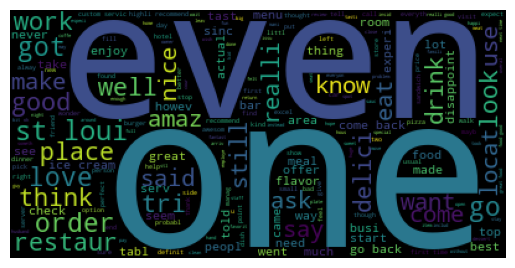

In [19]:
# global word cloud

wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

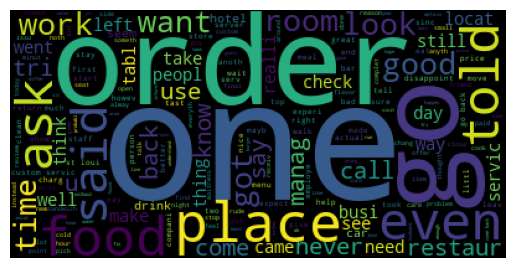

In [20]:
# word cloud for negative reviews

wordcloud = WordCloud().generate(" ".join(corpus_negative))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

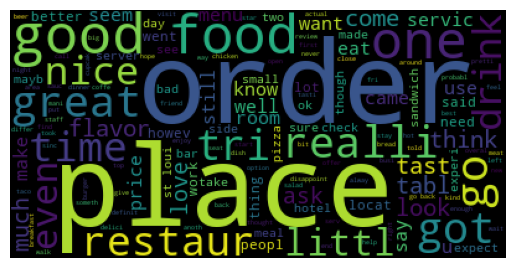

In [21]:
# word cloud for neutral reviews

wordcloud = WordCloud().generate(" ".join(corpus_neutral))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

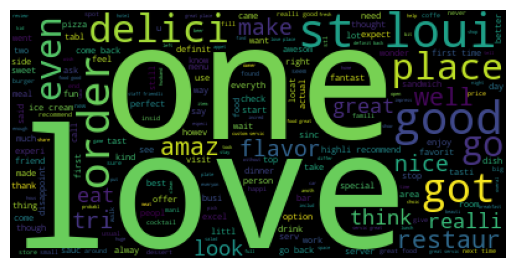

In [22]:
# word cloud for positive reviews

wordcloud = WordCloud().generate(" ".join(corpus_positive))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Frequency distributions

In [23]:
# frequency distribution of words

all_words = ' '.join(corpus).split()
fd = nltk.FreqDist(all_words)

negative_words = ' '.join(corpus_negative).split()
fd_negative = nltk.FreqDist(negative_words)

neutral_words = ' '.join(corpus_neutral).split()
fd_neutral = nltk.FreqDist(neutral_words)

positive_words = ' '.join(corpus_positive).split()
fd_positive = nltk.FreqDist(positive_words)

In [24]:
# most common words in reviews

fd.most_common(10)

[('not', 42129),
 ('food', 35440),
 ('place', 31302),
 ('good', 30388),
 ('great', 28333),
 ('time', 26324),
 ('order', 26060),
 ('get', 23867),
 ('go', 23124),
 ('like', 22237)]

In [25]:
# most common words in negative reviews

fd_negative.most_common(10)

[('not', 18160),
 ('order', 9368),
 ('food', 8680),
 ('time', 8510),
 ('get', 8263),
 ('no', 8002),
 ('would', 7257),
 ('one', 7146),
 ('go', 6989),
 ('place', 6716)]

In [26]:
# most common words in neutral reviews

fd_neutral.most_common(10)

[('not', 6319),
 ('good', 4949),
 ('food', 4507),
 ('order', 3481),
 ('like', 3430),
 ('place', 3353),
 ('time', 2899),
 ('get', 2820),
 ('would', 2641),
 ('go', 2557)]

In [27]:
# most common words in positive reviews

fd_positive.most_common(10)

[('great', 23994),
 ('food', 22253),
 ('place', 21233),
 ('good', 20477),
 ('not', 17650),
 ('time', 14915),
 ('go', 13578),
 ('order', 13211),
 ('servic', 12833),
 ('get', 12784)]